# Project 3
The prediction of molecular properties is an important task in drug discovery. The molecules' atomic composition and arrangement can already tell us a lot about their biological behavior. Each 2D molecule can be represented as a graph, where the nodes are atoms connected by edges corresponding to chemical bonds. The prediction of molecular properties can be formulized as a graph classification task, and graph neural network is usually applied for making graph-level prediction.

In this project, you need develop a model for predicting the toxicity of new molecules. This notebook provides a sample pipeline that establishes a baseline. It is expected that your methods should outperform this baseline. You are strongly encouraged to think about designing more powerful models, finetuning hyperparameters, developing better training strategies, etc.

# Install package

In [1]:
# New these two packages
!pip install torch_geometric
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 46.9 MB/s eta 0:00:00


# Some tutorials.



1.   Pytorch geometric package: https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html
2.   PyTorch Geometric for Graph-Based Molecular Property Prediction using MoleculeNet benchmark: https://medium.com/@nikopavl4/pytorch-geometric-for-graph-based-molecular-property-prediction-using-moleculenet-benchmark-41e36369d3c6
3. Graph neural networks for graph classification. https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing
4. Related github repository on molecular property predictions. https://github.com/yifeiwang15/MotifConv/tree/main/MCM_for_molecule_benchmarks


## What are node and edge features in a molecule.

### Node features:

**Atomic number**: Number of protons in the nucleus of an atom. It’s characteristic of a chemical element and determines its place in the periodic table.

**Chirality**: A molecule is chiral if it is distinguishable from its mirror image by any combination of rotations, translations, and some conformational changes. Different types of chirality exist depending on the molecule and the arrangement of the atoms.

**Degree**: Number of directly-bonded neighbors of the atom.
Formal charge: Charge assigned to an atom. It reflects the electron count associated with the atom compared to the isolated neutral atom.

**Number of H**: Total number of hydrogen atoms on the atom.
Number of radical e: Number of unpaired electrons of the atom.

**Hybridization**: Atom’s hybridization.

**Is aromatic**: Whether it is included in a cyclic structure with pi bonds. This type of structure tends to be very stable in comparison with other geometric arrangements of the same atoms.

**Is in ring**: Whether it is included in a ring (a simple cycle of atoms and bonds in a molecule).

### Edge features:

**Bond type:**: Whether the bond is single, double, triple, or aromatic.

**Stereo Type:** Stereo configuration of the bond.

**Is conjugated**: Whether or not the bond is considered to be conjugated.



# Dataset preparation and train-valid splitting.

In [2]:
import torch
import torch_geometric
import numpy as np
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet
import pickle

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU instead")

GPU is available


In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load datasets. The training and validation sets contain both molecules and their property labels. The test set only contain molecules.
# There are 12 property tasks for prediction. Some properties labels are missing (i.e., nan). You can ignore them.
train_dataset = torch.load("/content/drive/MyDrive/2023 Fall/cosi149 - project 3/project 3/train_data.pt/train_data.pt")
valid_dataset = torch.load("/content/drive/MyDrive/2023 Fall/cosi149 - project 3/project 3/valid_data.pt/valid_data.pt")
test_dataset = torch.load("/content/drive/MyDrive/2023 Fall/cosi149 - project 3/project 3/test_data.pt/test_data.pt")

# for g in train_dataset:
#   g.x = g.x.to(torch.float32)
# for g in test_dataset:
#   g.x = g.x.to(torch.float32)
# for tensor in valid_dataset:
#   g.x = g.x.to(torch.float32)

print(f'Size of training set: {len(train_dataset)}')
print(f'Size of validation set: {len(valid_dataset)}')
print(f'Size of test set: {len(test_dataset)}')

Size of training set: 6264
Size of validation set: 783
Size of test set: 784


In [130]:
# one graph example
g = train_dataset[1]
print(g)

print("Get node feature matrix:")
print(g.x)
print(g.x.shape) # (num_of_nodes, num_of_node_features)

print("Get edge index matrix:")
print(g.edge_index)
print(g.edge_index.shape) # (2, num_of_edges)

print("Get edge attribute matrix:")
print(g.edge_attr)
print(g.edge_attr.shape) # (num_of_edges, num_of_edge_features)

print("Get molecular property labels:")
print(g.y)
print(g.y.shape) # (1, 12)

Data(x=[20, 9], edge_index=[2, 38], edge_attr=[38, 3], y=[1, 12], smiles='CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C')
Get node feature matrix:
tensor([[6, 0, 4, 5, 3, 0, 4, 0, 0],
        [6, 0, 4, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 3, 0, 4, 0, 0],
        [6, 0, 4, 5, 3, 0, 4, 0, 0],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 3, 0, 4, 0, 0],
        [6, 0, 4, 5, 3, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 3, 0, 4, 0, 0],
        [6, 0, 4, 5, 3, 0, 4, 0, 0],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 3, 0, 4, 0, 0],
        [6, 0, 4, 5, 3, 0, 4, 0, 0],
        [6, 0, 4, 5, 3, 0, 4, 0, 0]])
torch.Size([20, 9])
Get edge index matrix:
tensor([[ 0,  1,  1,  1,  1,  2,  3,  4,  4,  5,  5,  6,  6,  6,  6,  7,  8,  

As we can observe, we have 11 nodes (rows) and each node has 9 features (columns). However, the features provided by Moleculenet are discrete and of type long, so we need to convert them first to continuous embeddings in order to feed them in any ML model.

For example, the first column indicates the atomic number of a node, where 1 represents Hydrogen, 6 represents Carbon, 8 for Oxygen, according to periodic table of elements.

In [5]:
# Example of preparing data loaders.
# You can use any batch size and see what happens in model performance.

from torch_geometric.data import DataLoader

batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# Visualization of molecules

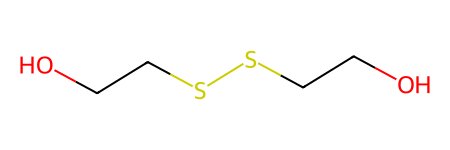

In [29]:
# visualize one 2D molecule.
from rdkit import Chem
Chem.MolFromSmiles(g.smiles)

# Build model

In [9]:
# Atom encoder

class AtomEncoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(AtomEncoder, self).__init__()

        self.embeddings = torch.nn.ModuleList()

        for i in range(9):
            self.embeddings.append(torch.nn.Embedding(100, hidden_channels))

    def reset_parameters(self):
        for embedding in self.embeddings:
            embedding.reset_parameters()

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(1)

        out = 0
        for i in range(x.size(1)):
            out += self.embeddings[i](x[:, i])

        return out

In [90]:
from rdkit import Chem
from rdkit.Chem import AllChem, RDKFingerprint, MACCSkeys


def generate_fingerprints(smiles_list, fingerprint_size=1024):
        fingerprints = []
        for smiles in smiles_list:
            molecule = Chem.MolFromSmiles(smiles)
            # molecule = Chem.RemoveHs(molecule)
            if molecule is not None:  # Check if the molecule conversion is successful
                fp = AllChem.GetMorganFingerprintAsBitVect(molecule, radius=2, nBits=fingerprint_size)
                # fp = MACCSkeys.GenMACCSKeys(molecule)
                # fp = RDKFingerprint(molecule)
                fingerprints.append(fp)
            else:
                fingerprints.append(None)  # Handle cases where SMILES conversion fails
        return fingerprints

In [ ]:
# multiheads GAT

import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool as gap
from torch.nn import Linear

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features, num_classes, num_heads=4):
        super(GAT, self).__init__()
        torch.manual_seed(42)
        self.emb = AtomEncoder(num_node_features)

        # Adjusted to include multi-head attention
        self.conv1 = GATConv(num_node_features, hidden_channels, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, concat=True)
        self.conv3 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, concat=False)  # Concat=False for the last layer

        self.fingerprint_lin = Linear(1024, hidden_channels)
        self.lin = Linear(hidden_channels*2, num_classes)

    def forward(self, batch):
        x, edge_index, edge_attr, batch_size, batch_smiles = batch.x, batch.edge_index, batch.edge_attr, batch.batch, batch.smiles
        x = self.emb(x)

        # 1. Obtain node embeddings using multi-head GATConv layers
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = self.conv3(x, edge_index, edge_attr)  # No ReLU after the last GATConv layer

        # 2. Readout layer
        x = gap(x, batch_size)  # [batch_size, hidden_channels]

        batch_fingerprints = generate_fingerprints(batch_smiles)
        batch_fingerprints = torch.tensor(batch_fingerprints, dtype=torch.float).to(x.device)  # Use the same device as x
        fingerprint = self.fingerprint_lin(batch_fingerprints).relu()
        x = torch.cat([x, fingerprint], dim=1)  # Concatenate along the feature dimension

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x


In [89]:
# GAT

from torch_geometric.nn import GATConv, global_mean_pool as gap
import torch.nn.functional as F
from torch.nn import Linear, LSTM

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features, num_classes):
        super(GAT, self).__init__()
        torch.manual_seed(42)
        self.emb = AtomEncoder(num_node_features)
        self.conv1 = GATConv(num_node_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)
        self.lstm = LSTM(input_size=hidden_channels, hidden_size=32, num_layers=2, batch_first=True)
        self.fingerprint_lin = Linear(1024, hidden_channels)
        self.lin = Linear(hidden_channels * 2, num_classes)

    def forward(self, batch):
        x, edge_index, edge_attr, batch_size, batch_smiles = batch.x, batch.edge_index, batch.edge_attr, batch.batch, batch.smiles
        x = self.emb(x)

        # 1. Obtain node embeddings using GATConv layers
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = self.conv3(x, edge_index, edge_attr)


        x, _ = self.lstm(x.view(batch_size, -1, x.size(1)))  # Reshape x for LSTM

        # 2. Readout layer
        x = gap(x, batch_size)  # [batch_size, hidden_channels]

        batch_fingerprints = generate_fingerprints(batch_smiles)
        batch_fingerprints = torch.tensor(batch_fingerprints, dtype=torch.float).to('cpu')
        fingerprint = self.fingerprint_lin(batch_fingerprints).relu()
        x = torch.cat([x, fingerprint], dim=1).to('cpu')



        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x


In [ ]:
# fingerprint + GCN

from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool as gap
import torch.nn.functional as F
from torch.nn import Linear

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features, num_classes, fingerprint_dim=167):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.emb = AtomEncoder(hidden_channels=32)
        self.conv1 = GCNConv(hidden_channels,hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.fingerprint_lin = Linear(fingerprint_dim, hidden_channels)
        self.lin = Linear(hidden_channels * 2, num_classes)

    def forward(self, batch):
        x , edge_index, batch_size, batch_smiles = batch.x, batch.edge_index, batch.batch, batch.smiles
        x = self.emb(x)
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = gap(x, batch_size)  # [batch_size, hidden_channels]
        # 3. Generate fingerprints and take them into consideration
        batch_fingerprints = generate_fingerprints(batch_smiles)
        batch_fingerprints = torch.tensor(batch_fingerprints, dtype=torch.float).to('cuda')
        fingerprint = self.fingerprint_lin(batch_fingerprints).relu()
        x = torch.cat([x, fingerprint], dim=1).to('cuda')

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

In [ ]:
# graph embedding + gcn
import pandas as pd
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool as gap
import torch.nn.functional as F
from torch.nn import Linear
import networkx as nx
from karateclub import Graph2Vec

def generate_g_embedding(smiles):
    smiles = pd.Series(smiles)
    mol = smiles.apply(lambda x: Chem.MolFromSmiles(x))
    graphs = mol.apply(lambda x: mol_to_nx(x))
    graph2vec = Graph2Vec()
    graph2vec.fit(graphs)
    embeddings = graph2vec.get_embedding()

def mol_to_nx(mol):
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   is_aromatic=atom.GetIsAromatic(),
                   atom_symbol=atom.GetSymbol())

    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())

    return G


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features, num_classes):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(hidden_channels,hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, batch):
        x , edge_index, batch_size, batch_smiles = batch.x, batch.edge_index, batch.batch, batch.smiles
        x = generate_g_embedding(batch_smiles)
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = gap(x, batch_size)  # [batch_size, hidden_channels]
        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

In [ ]:
# base model + fingerprint

from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool as gap
import torch.nn.functional as F
from torch.nn import Linear
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features, num_classes):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.emb = AtomEncoder(hidden_channels=32)
        self.conv1 = GCNConv(hidden_channels,64)
        self.conv2 = GCNConv(64, 128)
        self.conv3 = GCNConv(128, 32)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, batch):
        x , edge_index, batch_size = batch.x, batch.edge_index, batch.batch
        x = self.emb(x)
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = gap(x, batch_size)  # [batch_size, hidden_channels]
        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

In [123]:
# base model
# A simple graph neural network model

from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool as gap
import torch.nn.functional as F
from torch.nn import Linear
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features, num_classes):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.emb = AtomEncoder(hidden_channels=32)
        self.conv1 = GCNConv(hidden_channels,hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, batch):
        x , edge_index, batch_size = batch.x, batch.edge_index, batch.batch
        x = self.emb(x)
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = gap(x, batch_size)  # [batch_size, hidden_channels]
        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

In [6]:
from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter, BatchNorm1d

from torch_geometric.nn import GATConv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha, size=None)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()
        self.bn1 = BatchNorm1d(hidden_channels)
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(hidden_channels, hidden_channels, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATConv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))
        x = self.bn1(x)

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = F.elu_(conv(x, edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu_()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out).relu_()

        # Predictor:
        out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def jittable(self) -> 'AttentiveFP':
        self.gate_conv = self.gate_conv.jittable()
        self.atom_convs = torch.nn.ModuleList(
            [conv.jittable() for conv in self.atom_convs])
        self.mol_conv = self.mol_conv.jittable()
        return self

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')

# Start training

In [17]:
# loss function and optimizer
import torch.nn as nn
import torch.optim as optim
# from torch_geometric.nn import AttentiveFP

# model = GCN(32, 9, 12).to(device)
# model = GAT(32, 9, 12).to(device)
model = AttentiveFP(64,128,12,3,3,3, 0.5).to(device)
emb = AtomEncoder(64)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = nn.BCEWithLogitsLoss(reduction = "none")

In [11]:
# train and eval function
from sklearn.metrics import roc_auc_score
def train(model, device, loader, optimizer):
    model.train()

    for step, batch in enumerate(loader):
        pred = model(emb(batch.x).to(device), batch.edge_index.to(device), batch.edge_attr.to(device), batch.batch.to(device))
        batch = batch.to(device)
        # pred = model(batch)
        y = batch.y.view(pred.shape).to(torch.float64)

        optimizer.zero_grad()
        ## ignore nan targets (unlabeled) when computing training loss.
        is_labeled = batch.y == batch.y
        loss = criterion(pred.to(torch.float32)[is_labeled], batch.y.to(torch.float32)[is_labeled]).mean()
        loss.backward()
        optimizer.step()



def eval(model, device, loader):
    model.eval()
    y_true = []
    y_pred = []
    # For every batch in test loader
    for batch in loader:

        batch = batch.to(device)
        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(emb(batch.x.to('cpu')).to(device), batch.edge_index.to(device), batch.edge_attr.to(device), batch.batch.to(device))
                # pred = model(batch)
            y_true.append(batch.y.view(pred.shape))
            y_pred.append(pred)

    y_true = torch.cat(y_true, dim = 0).cpu().numpy()
    y_pred = torch.cat(y_pred, dim = 0).cpu().numpy()

    # Compute the ROC - AUC score and store as history
    rocauc_list = []

    for i in range(y_true.shape[1]):
        #AUC is only defined when there is at least one positive data.
        if np.sum(y_true[:,i] == 1) > 0 and np.sum(y_true[:,i] == 0) > 0:
            # ignore nan values
            is_labeled = y_true[:,i] == y_true[:,i]
            rocauc_list.append(roc_auc_score(y_true[is_labeled,i], y_pred[is_labeled,i]))

    if len(rocauc_list) == 0:
        raise RuntimeError('No positively labeled data available. Cannot compute ROC-AUC.')

    return {'rocauc': sum(rocauc_list)/len(rocauc_list)}


In [18]:
# Training
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Start training...")

for epoch in range(20):
    print("====epoch " + str(epoch+1))

    # training
    train(model, device, train_loader, optimizer)

    # evaluating
    train_acc = eval(model, device, train_loader)
    val_acc = eval(model, device, val_loader)
    print({'Train': train_acc, 'Validation': val_acc})

    if val_acc['rocauc'] >= 0.8:
        break



Start training...
====epoch 1
{'Train': {'rocauc': 0.7580468302443402}, 'Validation': {'rocauc': 0.7225408067193076}}
====epoch 2
{'Train': {'rocauc': 0.7925747622521814}, 'Validation': {'rocauc': 0.7579771474090657}}
====epoch 3
{'Train': {'rocauc': 0.8071555642662115}, 'Validation': {'rocauc': 0.7642306137499991}}
====epoch 4
{'Train': {'rocauc': 0.8170826091967465}, 'Validation': {'rocauc': 0.781178944883595}}
====epoch 5
{'Train': {'rocauc': 0.8349139994998929}, 'Validation': {'rocauc': 0.7904917158486232}}
====epoch 6
{'Train': {'rocauc': 0.832617115564222}, 'Validation': {'rocauc': 0.790539201113592}}
====epoch 7
{'Train': {'rocauc': 0.8378519696881548}, 'Validation': {'rocauc': 0.7897770512755683}}
====epoch 8
{'Train': {'rocauc': 0.8400412385133839}, 'Validation': {'rocauc': 0.7846630886057966}}
====epoch 9
{'Train': {'rocauc': 0.84545162751883}, 'Validation': {'rocauc': 0.7890624186784083}}
====epoch 10
{'Train': {'rocauc': 0.8468598402249919}, 'Validation': {'rocauc': 0.79645

KeyboardInterrupt: ignored

In [231]:
torch.save(model.state_dict(), '/content/drive/MyDrive/attentiveFP_1.pt')